In [1]:
import json 
import numpy as np 
import pandas as pd 
from textblob import TextBlob
import matplotlib.pyplot as plt 
import seaborn as sns
from wordcloud import WordCloud
import os 
from glob import glob 
import re
import preprocessor as tp
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer

[nltk_data] Downloading package wordnet to /Users/mamu867/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mamu867/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
tanishq_files = glob(r'../data/raw/*anishq*.json')

tweets = []
for file in tanishq_files:
    print(f'Processing file: {file}')
    with open(file, encoding='utf-8') as f:
        temp = json.load(f)
        tweets.extend([tweet['full_text'] for tweet in temp if tweet['full_text'].isascii()])

print(f'Number of tweets extracted: {len(tweets)}')

tanishq_data = pd.DataFrame(tweets, columns=['Tweet'])

del tweets

Processing file: ../data/raw/ekatvambytanishq.json
Processing file: ../data/raw/BoycottTanishqJewelry.json
Processing file: ../data/raw/boycott_tanishq.json
Processing file: ../data/raw/BoycottTanishq2.json
Processing file: ../data/raw/BoycottTanishq.json
Number of tweets extracted: 9427


In [3]:
#tanishq_data['Hashtag'] = tanishq_data['Tweet'].apply(lambda x: re.findall(r'#(\w+)', x))
tanishq_data['Tweet'] = tanishq_data['Tweet'].apply(lambda x: re.sub(r'#(\w+)', r'\1', x))

In [4]:
# Removal of @mentions, RT's, HTTPs etc. 
tp.set_options(tp.OPT.URL, tp.OPT.EMOJI, tp.OPT.MENTION, tp.OPT.NUMBER) 
tanishq_data['Clean Tweet'] = tanishq_data['Tweet'].apply(tp.clean)

In [5]:
tanishq_data['Clean Tweet'] = tanishq_data['Clean Tweet'].str.lower()
tanishq_data['Clean Tweet'] = tanishq_data['Clean Tweet'].apply(lambda x: re.sub(r'[^\w\s]', '', (x)))

In [6]:
from ekphrasis.classes.segmenter import Segmenter
seg = Segmenter(corpus="Twitter") 

tanishq_data["Clean Tweet Segmented"] = tanishq_data["Clean Tweet"].apply(lambda x: [seg.segment(i) for i in x.split()])

Reading Twitter - 1grams ...
Reading Twitter - 2grams ...


In [7]:
# Tokenization, Stemming, removing stop words etc. 
lemmatizer = nltk.stem.WordNetLemmatizer()
w_tokenizer = TweetTokenizer()
stop_words = set(stopwords.words('english'))
tanishq_data['Clean Tweet'] = tanishq_data.apply(lambda x: ' '.join(x['Clean Tweet Segmented']), axis=1)
tanishq_data['Tokenized Tweet'] = tanishq_data['Clean Tweet'].apply(
    lambda x: [(lemmatizer.lemmatize(w)) for w in w_tokenizer.tokenize(x) if w not in stop_words])
tanishq_data['Clean Tokenized Tweet'] = tanishq_data['Tokenized Tweet'].apply(lambda x: ' '.join(set(x)))

In [8]:
tanishq_data[tanishq_data['Clean Tokenized Tweet'].str.contains("tanishqboycott")]

,Tweet,Clean Tweet,Clean Tweet Segmented,Tokenized Tweet,Clean Tokenized Tweet


In [9]:
# Subjectivity and Polarity of the tweets
tanishq_data['Subjectivity'] = tanishq_data['Clean Tokenized Tweet'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
tanishq_data['Polarity'] = tanishq_data['Clean Tokenized Tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)
tanishq_data['Sentiment'] = tanishq_data['Polarity'].apply(lambda x: "Positive" if x > 0 else "negative" if x < 0 else "Neutral")

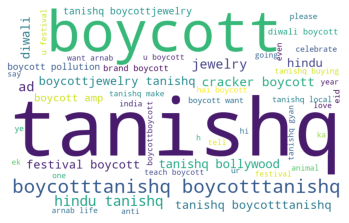

In [10]:
# Plot word cloud
words = "".join(tanishq_data["Clean Tokenized Tweet"])
wordcloud = WordCloud(height=500, width=800, max_font_size=200, max_words=50, background_color="white").generate(words)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [11]:
tanishq_data

,Tweet,Clean Tweet,Clean Tweet Segmented,Tokenized Tweet,Clean Tokenized Tweet,Subjectivity,Polarity,Sentiment
0,I hv been disappointed by the fact that Tanish...,i hv been disappointed by the fact that tanish...,"[i, hv, been, disappointed, by, the, fact, tha...","[hv, disappointed, fact, tanishq, pull, ad, be...",fact house ek wonder support ad vam troller cr...,0.875000,-0.187500,negative
1,@TanishqJewelry @RNTata2000 EkatvamByTanishq ...,ek at vam by tanishq thank you so much for bea...,"[ek at vam by tanishq, thank, you, so, much, f...","[ek, vam, tanishq, thank, much, beautiful, gif...",diwali thank ek beautiful stand united hind ja...,0.733333,0.616667,Positive
2,EkatvamByTanishq @tanishq HappyDiwali @sayanig...,ek at vam by tanishq happy diwali a wonderful ...,"[ek at vam by tanishq, happy diwali, a, wonder...","[ek, vam, tanishq, happy, diwali, wonderful, a...",diwali wonderful ek look gorgeous tanishq happ...,0.814286,0.625000,Positive
3,Hope @TanishqJewelry wishes d same on NewYears...,hope wishes d same on new years eve have u eve...,"[hope, wishes, d, same, on, new years eve, hav...","[hope, wish, new, year, eve, u, ever, greeted,...",hope _ 1 lar u ek year except feku vam diwali ...,0.454545,0.136364,Positive
4,@Ramesh_hjs @RituRathaur @HinduJagrutiOrg @rah...,this is called tan ishq ek atv am by ms r unit...,"[this, is, called, tan ishq ek atv am, by, ms,...","[called, tan, ishq, ek, atv, m, r, united, n, ...",_ tan vam diwali ek boycott m atv r united div...,0.000000,0.000000,Neutral
...,...,...,...,...,...,...,...,...
9422,@TanishqJewelry @AlayaF___ @NimratOfficial @Ne...,boycott tanishq,[boycott tanishq],"[boycott, tanishq]",tanishq boycott,0.000000,0.000000,Neutral
9423,Why every time same mistake boycotttanishq,why every time same mistake boycott tanishq,"[why, every, time, same, mistake, boycott tani...","[every, time, mistake, boycott, tanishq]",boycott every tanishq mistake time,0.000000,0.000000,Neutral
9424,boycotttanishq stop giving gyaan to us... Stop...,boycott tanishq stop giving gyaan to us stop k...,"[boycott tanishq, stop, giving, gyaan, to, us,...","[boycott, tanishq, stop, giving, gyaan, u, sto...",giving u boycott eid killing gyaan think tanis...,0.000000,0.000000,Neutral
9425,"So Diwali is only buying gold, ""nice"" clothes,...",so diwali is only buying gold nice clothes par...,"[so, diwali, is, only, buying, gold, nice, clo...","[diwali, buying, gold, nice, clothes, party, a...",victory nice clothes ur folk raks whether ad r...,0.866667,0.100000,Positive


In [12]:
pd.set_option('display.width', 1000)
tanishq_data[['Tweet', 'Polarity']].sort_values(by='Polarity').head(10).style.background_gradient()

,Tweet,Polarity
4367,@TanishqJewelry @AlayaF___ @NimratOfficial @Neenagupta001 @sayanigupta This deewali let's unite and boycotttanishq and punish them for insulting our festival.,-1.000000
8372,"Seriously @TanishqJewelry, no word to ban shameless animal slaughter on Eid?? boycotttanishq! Dhanteras we buy silver coins from tanishq but no more! Disgusting! https://t.co/AbikqeKS3Q",-1.000000
4408,"boycotttanishq we do , worst brand in the world",-1.000000
9396,"boycotttanishq we do , worst brand in the world",-1.000000
1594,"@sayanigupta ""Axone"" me meat banana culture and tradition h, par Diwali me firecrackers nahi. boycotttanishq Hypocrite Killing animals in the name of religion is disgusting too.",-1.000000
5355,"Being an ex Tata Tanishq employee, I feel disgusted... Stop teaching us how to celebrate our festivals boycotttanishq @TanishqJewelry https://t.co/oktsZj1ss4",-1.000000
9355,@TanishqJewelry @AlayaF___ @NimratOfficial @Neenagupta001 @sayanigupta This deewali let's unite and boycotttanishq and punish them for insulting our festival.,-1.000000
8168,boycotttanishq it's more worst to feed anti hindus than burning crackers https://t.co/DAxIhS96ZO,-1.000000
5047,@kshtriy_maratha @_PreetiPandey @mamta_kale @anujakapurindia @TanishqJewelry Tq abhi toh tera pradhushan nikala tha tu fir bola 4 us Hindu it is celebration of victory over evil boycotttanishq Btw i havnt brought any nonsense in my life fm Tanishq V buy our gold from Sonar kaka Whn he pack our gold thy put puja ka phool in our gold NationStands4Arnab,-1.000000
6582,"@sayanigupta ""Axone"" me meat banana culture and tradition h, par Diwali me firecrackers nahi. boycotttanishq Hypocrite Killing animals in the name of religion is disgusting too.",-1.000000


In [13]:
tanishq_data[['Tweet', 'Polarity']].sort_values(by='Polarity', ascending=False).head(10).style.background_gradient()

,Tweet,Polarity
4409,Awesome KaneWilliamson DelhiCapitals boycotttanishq DCvsSRH Arnab Dhoni https://t.co/l8SsvxTVAZ,1.000000
8336,@satyasunaam1 @SwarajyaMag Best thing to do is boycotttanishq,1.000000
3464,boycotttanishq. This company should learn advisertising from Cadbury..the best Diwali ad seen for Diwali,1.000000
9397,Awesome KaneWilliamson DelhiCapitals boycotttanishq DCvsSRH Arnab Dhoni https://t.co/l8SsvxTVAZ,1.000000
3348,@satyasunaam1 @SwarajyaMag Best thing to do is boycotttanishq,1.000000
7652,Best Hair Loss Treatment in Delhi - Immer Organic https://t.co/EtMbglDqZI hairfall hairfallsolution hairloss hairlosstreatment ReasonsOfHairFall HairLossTreatmentinDelhi HairFallTreatmentinDelhi Adipurush JusticeForAishwarya boycotttanishq,1.000000
2664,Best Hair Loss Treatment in Delhi - Immer Organic https://t.co/EtMbglDqZI hairfall hairfallsolution hairloss hairlosstreatment ReasonsOfHairFall HairLossTreatmentinDelhi HairFallTreatmentinDelhi Adipurush JusticeForAishwarya boycotttanishq,1.000000
3668,People who are on for boycotttanishq are jus ass hole & their family too bcz dey educate these ass holes to be wht dey r.. Only @TanishqJewelry best in quality best in lot.. tanishqjewelry is a faith & believe. isupporttanishq,1.000000
8768,Keep at it moroons with your two-bit wisdom on Hinduism. Your boycotttanishq rants will have zero effect on people like myself who finds tanishqisbest,1.000000
8466,boycotttanishq awesome tanishq . https://t.co/YX5NDpxBgP,1.000000


In [14]:
tanishq_data["Sentiment"].value_counts()

Neutral     6961
Positive    1512
negative     954
Name: Sentiment, dtype: int64

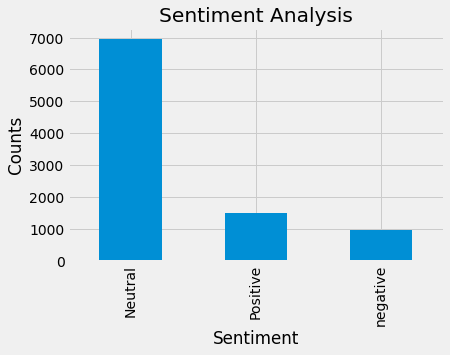

In [15]:
plt.style.use("fivethirtyeight")
tanishq_data["Sentiment"].value_counts().plot(kind="bar")
plt.title("Sentiment Analysis")
plt.xlabel("Sentiment")
plt.ylabel("Counts")
plt.show()